In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d

import plotly.graph_objects as go
import plotly.express as px
import plotly.colors

import numpy as np
import pandas as pd
import tqdm

from mvf_bto.data_loading import load_data

2022-10-23 13:34:41.066917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-23 13:34:41.066941: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading Data

In [2]:
# data_path = "/Users/anoushkabhutani/PycharmProjects/10701-mvf-bto/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"
data_path = "/home/amalss/Documents/CMU/Courses/10701/project/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"

In [3]:
data = load_data(file_path= data_path, num_cells= 3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.14s/it]


In [4]:
single_cell_data = data['b1c2']['cycles']

## Preprocessing Data

In [5]:
df_list = []
max_cycle = 1175
for cycle_key, time_series in tqdm.tqdm(single_cell_data.items()):
    cycle_num = int(cycle_key)
    if cycle_num<1:
        continue
    df = pd.DataFrame({'t': time_series['t'], 
                       'V': time_series['V'],
                       'temp': time_series['T'],
                       'I': time_series['I'],
                       'Qd': time_series['Qd'],
                      }
                       )
    # drop duplicates to be able to interpolate over capacity
    df = df.drop_duplicates(subset='Qd')
    
    
    # get discharge part of curve only (current is negative during discharge)
    df = df[df.I<-3.85]
    
    # normalize voltage and temperature using fixed thershold's to avoid data leakage
    df['V_norm'] = (df.V-1.9)/(3.5-1.9)
    df['T_norm'] = (df.temp-24)/(38-24)
    
    interp_df = pd.DataFrame()
    # use capacity as reference to interpolate over
    Q_eval = [0, 0.0125, 0.025, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.85, 0.9, 0.95, 0.975, 0.98, 0.99, 1.0, 1.005, 1.01, 1.015, 1.02]
    interp_df['Q_eval'] = Q_eval
    fV = interp1d(x=df.Qd, y =df.V_norm, kind='quadratic', fill_value='extrapolate')
    interp_df['V_norm'] = fV(Q_eval)
    ft = interp1d(x=df.Qd, y =df.t, kind='quadratic', fill_value='extrapolate')
    interp_df['t'] = ft(Q_eval)
    fT = interp1d(x=df.Qd, y =df['T_norm'], kind='quadratic', fill_value='extrapolate')
    interp_df['T_norm'] = fT(Q_eval)
    
    interp_df['Cycle'] = [cycle_num/max_cycle for i in range(len(interp_df))]
    
    df_list.append(interp_df)
print(len(Q_eval))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1176/1176 [00:07<00:00, 148.14it/s]

22


## What does raw versus interpolated data look like?

In [6]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x = df.Qd, y = df.V_norm, showlegend=True, mode="markers", name="Raw"))
# fig.add_trace(go.Scatter(x = interp_df.Q_eval, y = interp_df.V_norm, showlegend=True, mode="markers+lines" , name="Interpolated"))

In [34]:
# multivariate data preparation
# TODO: multi output (temperature + voltage) (Hancheng)
# TODO: multiple time steps in the future 
X_list, y_list = [], []

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, nf_steps):
    X, y = list(), list()
    for i in range(len(sequences)):#-nf_steps-n_steps+1
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
            # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix-1, :-1], sequences[end_ix-1, -1]#[sequences[end_ix+j-1, -1] for j in np.arange(nf_steps)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

for df in df_list:
    # define input sequence
    in_seq1 = df['T_norm'].values
    in_seq2 = df['Q_eval'].values
    in_seq3 = df['V_norm'].values
    in_seq4 = df['Cycle'].values
    out_seq = df['V_norm'].values

    #Set number of steps into the future to predict
    nf_steps = 1
    
    # convert to [rows, columns] structure
    in_seq1 = in_seq1.reshape((len(in_seq1), 1))
    in_seq2 = in_seq2.reshape((len(in_seq2), 1))
    in_seq3 = in_seq3.reshape((len(in_seq3), 1))
    in_seq4 = in_seq4.reshape((len(in_seq4), 1))#cycle
    out_seq = out_seq.reshape((len(out_seq), 1))
    
    # horizontally stack columns
    dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, out_seq))
    
    # choose a number of time steps (for input window)
    n_steps = 4
    
    # convert into input/output
    X_cycle, y_cycle = split_sequences(dataset, n_steps, nf_steps)
    # print(y_cycle.shape)
    X_list.append(X_cycle)
    y_list.append(y_cycle)

print(np.array(X_list).shape, np.array(y_list).shape)
print(y_list[0])

(1175, 19, 3, 4) (1175, 19)
[0.80128466 0.79657455 0.78557444 0.77622965 0.76584175 0.75338571
 0.73975863 0.70033711 0.68486792 0.66376085 0.63206181 0.60819379
 0.6023248  0.58880156 0.57224826 0.56251663 0.55150439 0.53924956
 0.52517859]


In [23]:
batch_size = X_cycle.shape[0] 
print(batch_size)
# batch_size must be equal to the length of 1 input curve
# since for a stateful LSTM the cell state is cleared after a batch
# (look at the keras docs)
# we could write over own custom callback if we need batch_size != sequence_length
# (for the use t prediction as t+1 input case)
# but I'm not sure if that's acceptable practice

window_length = X_cycle.shape[1]
n_features = X_cycle.shape[2]

18


In [24]:
X_train = np.array([item for index, item in enumerate(X_list) if index % 100 != 0])
X_test = np.array([item for index, item in enumerate(X_list) if index % 100 == 0])

# y_train = np.array([[y_list[idx] for idx in np.arange(index, index + nf_steps)] for index, item in enumerate(y_list) if (index % 100 != 0) and (index < len(y_list) - nf_steps + 1)])
# y_train = np.array([[y_list[idx] for idx in np.arange(index, index + nf_steps)] for index, item in enumerate(y_list) if (index % 100 == 0) and (index < len(y_list) - nf_steps + 1)])
y_train = np.array([item for index, item in enumerate(y_list) if index % 100 != 0])
y_test = np.array([item for index, item in enumerate(y_list) if index % 100 == 0])

# y_test = y_test.flatten()
# y_train = y_train.flatten()

X_train = X_train.reshape(X_train.shape[0]*batch_size, X_train[0].shape[1] , X_train.shape[-1])
X_test = X_test.reshape(X_test.shape[0]*batch_size,X_test[0].shape[1], X_test.shape[-1])

y_train = y_train.reshape(y_train.shape[0]*batch_size, y_train.shape[-1])
y_test = y_test.reshape(y_test.shape[0]*batch_size, y_test.shape[-1])

print(X_train.shape)
print(y_train.shape)

(20934, 3, 4)
(20934, 1)


In [10]:
sample_weight = np.ones(y_train.shape)

# TODO: experiment with different sample weights and thersholds
# (this is a arbitary guess)
sample_weight[y_train<0.6]=2
sample_weight[y_train<0.5]=3

In [25]:
# define model
# TODO: hyperparameter tuning (Anoushka)
model = Sequential()
model.add(LSTM(32, return_sequences=True, stateful=True, batch_input_shape=(batch_size, 3, 4)))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation="sigmoid"))
model.add(Dense(8))
# need to change here (maybe) if n steps into the future
model.add(Dense(nf_steps))

model.compile(optimizer='adam', loss='mse')

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (18, 3, 32)               4736      
                                                                 
 lstm_3 (LSTM)               (18, 16)                  3136      
                                                                 
 dense_1 (Dense)             (18, 32)                  544       
                                                                 
 dense_2 (Dense)             (18, 8)                   264       
                                                                 
 dense_3 (Dense)             (18, 1)                   9         
                                                                 
Total params: 8,689
Trainable params: 8,689
Non-trainable params: 0
_________________________________________________________________


In [27]:
# TODO: add validation set or validation split + early stopping
n_epochs = 50
print(X_train.shape, y_train.shape)
history = model.fit(X_train, y_train, 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    shuffle=False, 
                    verbose=1)

(20934, 3, 4) (20934, 1)
Epoch 1/50
1163/1163 [==============================] - 9s 4ms/step - loss: 7.9362e-04
Epoch 2/50
1163/1163 [==============================] - 5s 4ms/step - loss: 6.8641e-04
Epoch 3/50
1163/1163 [==============================] - 5s 4ms/step - loss: 6.3677e-04
Epoch 4/50
1163/1163 [==============================] - 5s 4ms/step - loss: 6.0342e-04
Epoch 5/50
1163/1163 [==============================] - 5s 4ms/step - loss: 4.7297e-04
Epoch 6/50
1163/1163 [==============================] - 5s 4ms/step - loss: 4.1570e-04
Epoch 7/50
1163/1163 [==============================] - 5s 5ms/step - loss: 3.6728e-04
Epoch 8/50
1163/1163 [==============================] - 5s 4ms/step - loss: 3.1322e-04
Epoch 9/50
1163/1163 [==============================] - 5s 5ms/step - loss: 3.0535e-04
Epoch 10/50
1163/1163 [==============================] - 7s 6ms/step - loss: 2.4123e-04
Epoch 11/50
1163/1163 [==============================] - 5s 5ms/step - loss: 2.0721e-04
Epoch 12/50
1163

Text(0, 0.5, 'Loss (MSE)')

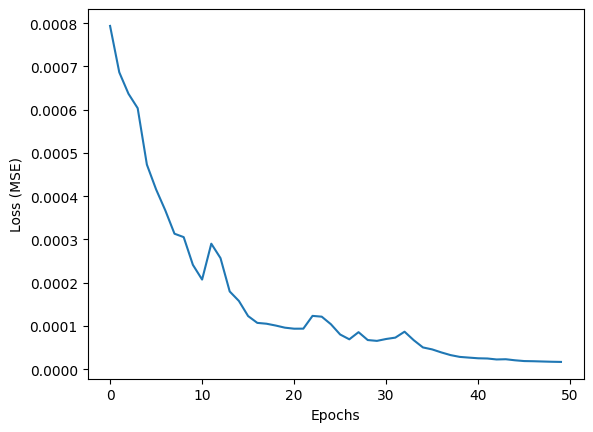

In [28]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x = np.linspace(1,50), y = history.history['loss'],
#                          showlegend=False, mode="markers+lines"))
# fig.update_xaxes(title='Epochs')
# fig.update_yaxes(title='Loss (MSE)')

#Matplotlib code
import matplotlib.pyplot as plt 
plt.plot(np.arange(n_epochs), history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")

## Parity Plot of Training Error

Text(0, 0.5, 'Normalized prediction')

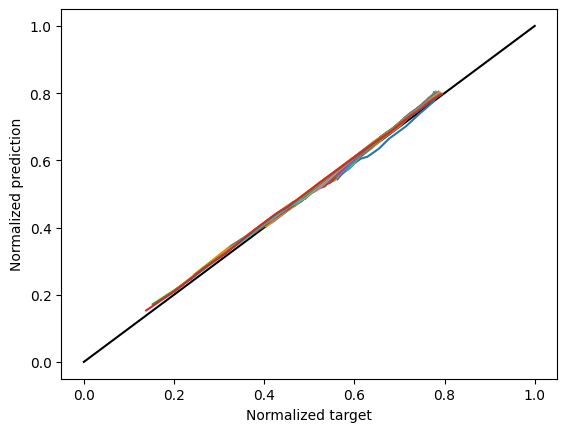

In [15]:
# random plotting traing error at some interval = skip to not make the plot rendering too slow
skip = 50

# fig = go.Figure()
# fig.add_trace(go.Scatter(x = [0,1], y = [0,1], showlegend=False, mode="markers+lines"))
# for i in range(0,len(X_train), batch_size*skip):
#     fig.add_trace(go.Scatter(x = model.predict(X_train[i:i+batch_size],verbose=0).flatten(), 
#                              y = y_train[i:i+batch_size], 
#                              showlegend=False, mode="markers+lines"))
# fig.update_yaxes(title='Normalized Target')
# fig.update_xaxes(title='Normalized Prediction')

#Matplotlib code
plt.plot([0, 1], [0, 1], color='black')
# print(y_train[0:batch_size])
# print(model.predict(X_train[i:i+batch_size], verbose=0))
for i in range(0, len(X_train), batch_size*skip):
    for j in range(nf_steps):
        plt.plot(model.predict(X_train[i:i+batch_size], verbose=0)[:, j],
                 y_train[i:i+batch_size][:, j], label=f"{i}")

plt.xlabel("Normalized target")
plt.ylabel("Normalized prediction")
# plt.legend()

## Parity Plot of Test Error

Text(0, 0.5, 'Normalized prediction')

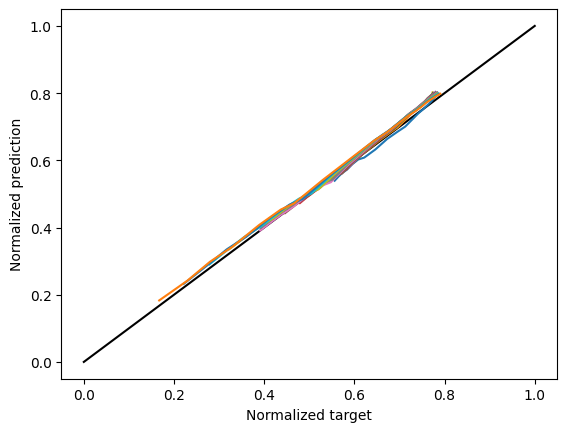

In [16]:
# pallete = plotly.colors.qualitative.Dark24*10

# fig = go.Figure()
# fig.add_trace(go.Scatter(x = [0,1], y = [0,1], showlegend=False, mode="markers+lines"))

# for i in range(0, len(X_test), batch_size):
#     fig.add_trace(go.Scatter(x = model.predict(X_test[i:i+batch_size],verbose=0).flatten(), 
#                              y = y_test[i:i+batch_size], 
#                              showlegend=False, mode="markers+lines", name='batch',
#                              line_color = pallete[i]))
# fig.update_yaxes(title='Normalized Target')
# fig.update_xaxes(title='Normalized Prediction')

#Matplotlib code
plt.plot([0, 1], [0, 1], color='black')
for i in range(0, len(X_test), batch_size):
    for j in range(nf_steps):
        plt.plot(model.predict(X_test[i:i+batch_size], verbose=0)[:, j],
                 y_test[i:i+batch_size][:, j], label=f"{i}")

plt.xlabel("Normalized target")
plt.ylabel("Normalized prediction")


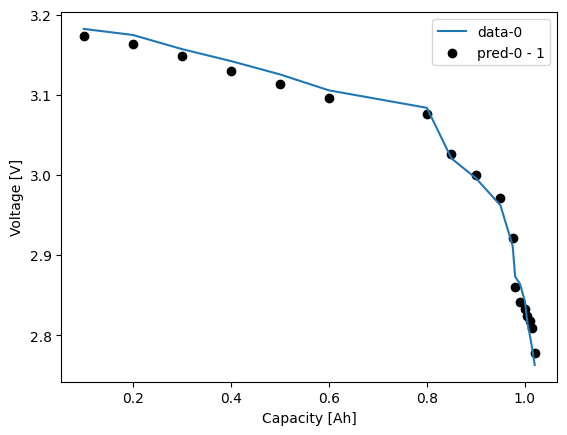

In [29]:
# fig = go.Figure()
# for i in range(0, len(X_test), batch_size):
#     V_actual = y_test[i:i+batch_size]
#     V_pred = model.predict(X_test[i:i+batch_size],verbose=0).flatten()
#     fig.add_trace(go.Scatter(x = Q_eval, y = V_actual*(3.5-1.9)+1.9, 
#                              mode='lines', name = 'data', 
#                              line_color = pallete[i]))
#     fig.add_trace(go.Scatter(x = Q_eval, y = V_pred*(3.5-1.9)+1.9,
#                              mode='markers', name = 'prediction', 
#                              line_color = pallete[i]))
# fig.update_yaxes(title="Voltage [V]")
# fig.update_xaxes(title="Capacity [Ah]")

# Matplotlib code
N = len(Q_eval) - batch_size
shift = nf_steps - 1
for i in range(0, len(X_test), batch_size):
    V_actual = y_test[i:i+batch_size]
    V_pred = model.predict(X_test[i:i+batch_size],verbose=0)
    plt.plot(Q_eval[N:], V_actual[:, 0]*(3.5-1.9)+1.9, label=f"data-{i}")
    plt.scatter(Q_eval[N:], V_pred[:, 0]*(3.5-1.9)+1.9, label=f"pred-{i} - 1", color='black')
    # plt.scatter(Q_eval[N + shift:], V_pred[:, 1][:-1*shift]*(3.5-1.9)+1.9, label=f"pred-{i} - 2", color='red')
    break
plt.ylabel("Voltage [V]")
plt.xlabel("Capacity [Ah]")
plt.legend()

In [30]:
print(y_test[0:batch_size][:,0])

[0.80128466 0.79657455 0.78557444 0.77622965 0.76584175 0.75338571
 0.73975863 0.70033711 0.68486792 0.66376085 0.63206181 0.60819379
 0.6023248  0.58880156 0.57224826 0.56251663 0.55150439 0.53924956]


array([[0.80128466],
       [0.79657455],
       [0.78557444],
       [0.77622965],
       [0.76584175],
       [0.75338571],
       [0.73975863],
       [0.70033711],
       [0.68486792],
       [0.66376085],
       [0.63206181],
       [0.60819379],
       [0.6023248 ],
       [0.58880156],
       [0.57224826],
       [0.56251663],
       [0.55150439],
       [0.53924956]])